# Master d'Apprentissage Automatique en Langue: Day-2

## Sécurité des applications de messagerie électronique : cas de la détection automatique des spams

Dans ce notebook nous allons explorer la **classification** comme technique d'apprentissage automatique pour l'identification des couriels de type spam. Nous illustrerons le pretraitement des données en traitement automatique du langage et analyserons la performance du modèle.


Présenté par **Maxwell Ndognkong Manga**   maxwellndogkong@gmail.com

## Jeu de données
Le jeu de données utilisé provient de deux sources:
* ENRON email archive http://www.aueb.gr/users/ion/data/enron-spam/
* Apache Spam Assassin dataset https://spamassassin.apache.org/publiccorpus/
* application (https://spamassassin.apache.org/downloads.cgi?update=201809160000)


### I- Chargement des librairies

In [57]:

%matplotlib inline
import os
import sys
import itertools
import numpy as np
import pandas as pf
from pandas import DataFrame 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline ## Workflow de traitement des données
from sklearn.cross_validation import KFold # Validation croisée des modèles
from sklearn.metrics import confusion_matrix, f1_score
import matplotlib.pyplot as plt #Visualisation des données de traitement%
import numpy

### II- Défintion des fonctions de pré traitement des données

In [58]:
HAM = 'ham' # Courriel non SPAM
SPAM = 'spam'# Courriel SPAM

SOURCES = [
    ('..\data\small\spam_2',            SPAM),
    ('..\data\small\easy_ham_2',        HAM)
    #('..\data\small\hard_ham',        HAM)
]

SKIP_FILES = {'cmds'}

def progress(i, end_val, bar_length=50):
    '''
    Print a progress bar of the form: Percent: [#####      ]
    i is the current progress value expected in a range [0..end_val]
    bar_length is the width of the progress bar on the screen.
    '''
    percent = float(i) / end_val
    hashes = '#' * int(round(percent * bar_length))
    spaces = ' ' * (bar_length - len(hashes))
    sys.stdout.write("\rPercent: [{0}] {1}%".format(hashes + spaces, int(round(percent * 100))))
    sys.stdout.flush()

NEWLINE = '\n'

def lecture_fichiers(path): 
    '''
    Génère la paire (chemin du , contenu mail)
    Le contenu de chaque page Web est sous format HTML:
        header....
        <emptyline>
        body...
    This skips the headers and returns body only.
    '''
    for root, dir_names, file_names in os.walk(path):
        for path in dir_names:
            read_files(os.path.join(root, path))
        for file_name in file_names:
            if file_name not in SKIP_FILES:
                file_path = os.path.join(root, file_name)
                if os.path.isfile(file_path):
                    past_header, lines = False, []
                    f = open(file_path, encoding="latin-1")
                    for line in f:
                        if past_header:
                            lines.append(line)
                        elif line == NEWLINE:
                            past_header = True
                    f.close()
                    content = NEWLINE.join(lines)
                    yield file_path, content


def build_data_frame(l, path, classification):
    rows = []
    index = []
    for i, (file_name, text) in enumerate(lecture_fichiers(path)):
        #if ((i+l) % 100 == 0):
        #    progress(i+l, 58910, 50)
        rows.append({'text': text, 'class': classification})
        index.append(file_name)
   
    data_frame = DataFrame(rows, index=index)
    return data_frame, len(rows)

def load_data():
    data = DataFrame({'text': [], 'class': []})
    l = 0
    for path, classification in SOURCES:
        data_frame, nrows = build_data_frame(l, path, classification)
        data = data.append(data_frame)
        l += nrows
    data = data.reindex(numpy.random.permutation(data.index))
    return data

In [59]:
data = load_data()

### Taille des données

In [60]:
print(len(data))

2797


In [64]:
data[0:5]

,class,text
..\data\small\easy_ham_2\00185.b6902dc0d90f39f906bae90a74907357,ham,"""Good"" ol dos fdisk /mbr should do the twick\n..."
..\data\small\easy_ham_2\00999.8251f0edaf61311f630039a20c6d7cb0,ham,"On Thu, 8 Aug 2002, Adam L. Beberg wrote:\n\n\..."
..\data\small\easy_ham_2\00725.1ff00314bb409ff8506cd3d6f704d56a,ham,"In message <5378.1027548783@dimebox>, Hal DeVo..."
..\data\small\spam_2\01151.e295c81d698d58f43f17bde22076cbef,spam,"Dear friend,\n\nMay I briefly introduce myself..."
..\data\small\spam_2\01307.270e0fd3d0f0a14a592fcc47f3696e05,spam,<!-- saved from url=3D(0022)http://internet.e-...


### Info des données

In [65]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2797 entries, ..\data\small\easy_ham_2\00185.b6902dc0d90f39f906bae90a74907357 to ..\data\small\easy_ham_2\00592.4ec37bb1a3a2ffab9cb80b8568c907dc
Data columns (total 2 columns):
class    2797 non-null object
text     2797 non-null object
dtypes: object(2)
memory usage: 65.6+ KB


### Description des données

In [66]:
data.describe()

,class,text
count,2797,2797
unique,2,2684
top,ham,\n\nHello I am your hot lil horny toy.\n\n ...
freq,1400,7


## Modèle de sac à mots (Bag of Words) pour extraction des caractéristiques

<img src="..\images\bag_of_words.png">

### Analyse lexicale des contenus de mail

In [67]:
corpus = [
   'Ceci est un premier document.',
   'Le contenu de ce document est-il un SPAM.',
   'Ce contenu est de document n\'est pas un SPAM.',
   'Vous avez gagnez le Loto?',
   'Que dira l\'analyse lexicale'
 ]

### Impact de Analyseur lexicale avec la méthode CountVectorizer

In [68]:
def lexical(corpus,vectorizer):
    X = vectorizer.fit_transform(corpus)
    word_count = DataFrame(X.A, columns=vectorizer.get_feature_names())
    return word_count

In [69]:
vectorizer = CountVectorizer()
lexical(corpus,vectorizer)
#X = vectorizer.fit_transform(corpus)
#print("Vocabulaire induit: ",vectorizer.get_feature_names())

#print("Occurence des mots")  
#word_count = DataFrame(X.A, columns=vectorizer.get_feature_names())
#word_count

,analyse,avez,ce,ceci,contenu,de,dira,document,est,gagnez,il,le,lexicale,loto,pas,premier,que,spam,un,vous
0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0
1,0,0,1,0,1,1,0,1,1,0,1,1,0,0,0,0,0,1,1,0
2,0,0,1,0,1,1,0,1,2,0,0,0,0,0,1,0,0,1,1,0
3,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1
4,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0


**Problème** On observe de cette fonction que la matrice est creuse \

In [70]:
vectorizer2 =  CountVectorizer(ngram_range=(1, 2))

In [71]:
lexical(corpus,vectorizer2)

,analyse,analyse lexicale,avez,avez gagnez,ce,ce contenu,ce document,ceci,ceci est,contenu,...,premier,premier document,que,que dira,spam,un,un premier,un spam,vous,vous avez
0,0,0,0,0,0,0,0,1,1,0,...,1,1,0,0,0,1,1,0,0,0
1,0,0,0,0,1,0,1,0,0,1,...,0,0,0,0,1,1,0,1,0,0
2,0,0,0,0,1,1,0,0,0,1,...,0,0,0,0,1,1,0,1,0,0
3,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
4,1,1,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0


In [72]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #plt.tight_layout()

## Exploration des motifs (mots du vocabulaire) dans les données des Emails

In [73]:
vectorizer2 =  CountVectorizer()
data_features = lexical(data["text"], vectorizer2)
data_features.head()

,00,000,0000,00000,000000,00000000,0000000000,00000000000000000,000000000000000000000,000000000000000000000000,...,þày,þë,þö,þööööà,ÿò,ÿÿ,ÿÿã,ÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿò,ÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿô,ÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿó
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


La taille des données en entrée est de **58 645**
Certaines variables sont encodées il faut prétraiter

# Install nltk

In [74]:
#!python -m pip install nltk

In [75]:
import re
import string
from nltk.tokenize import word_tokenize

In [31]:
def retrait_url(word):
    return  re.sub(r"http\S+", "", word)

In [76]:
def to_lower(word):
    result = word.lower()
    return result

In [77]:
def retrait_nombre(word):
    result = re.sub(r'\d+', '', word)
    return result

In [78]:
def retrait_ponctuation(word):
    result = word.translate(str.maketrans(dict.fromkeys(string.punctuation)))
    return result

In [79]:
def retrait_espace(word):
    result = word.strip()
    return result

In [80]:
def retrait_saut_ligne(word):
    return word.replace('\n','')

In [81]:
def clean_up_pipeline(sentence):
    cleaning_utils = [retrait_url,
                      retrait_saut_ligne,
                      to_lower,
                      retrait_nombre,
                      retrait_ponctuation,retrait_espace]
    for o in cleaning_utils:
        sentence = o(sentence)
    return sentence

In [82]:
data_train = [clean_up_pipeline(o) for o in data["text"]]

In [83]:
data["word_clean"]= data_train
data.head()

,class,text,word_clean
..\data\small\easy_ham_2\00185.b6902dc0d90f39f906bae90a74907357,ham,"""Good"" ol dos fdisk /mbr should do the twick\n...",good ol dos fdisk mbr should do the twickbutbu...
..\data\small\easy_ham_2\00999.8251f0edaf61311f630039a20c6d7cb0,ham,"On Thu, 8 Aug 2002, Adam L. Beberg wrote:\n\n\...",on thu aug adam l beberg wroteyea apple suck...
..\data\small\easy_ham_2\00725.1ff00314bb409ff8506cd3d6f704d56a,ham,"In message <5378.1027548783@dimebox>, Hal DeVo...",in message dimebox hal devore writes on wed j...
..\data\small\spam_2\01151.e295c81d698d58f43f17bde22076cbef,spam,"Dear friend,\n\nMay I briefly introduce myself...",dear friendmay i briefly introduce myself to y...
..\data\small\spam_2\01307.270e0fd3d0f0a14a592fcc47f3696e05,spam,<!-- saved from url=3D(0022)http://internet.e-...,saved from urld htmlheadmeta httpequivdcontent...


### Visualisation du nettoyage

In [84]:
data.iloc[3]['text']

"Dear friend,\n\nMay I briefly introduce myself to you. I am Hajia Maryam Abacha, the wife of late Nigerian Head of State, General Sanni Abacha, who died on the 8th of June 1998. ever since the death of my husband, my family has been facing a lot of problems mostly with the present civilian government. Consequently, my son - Mohammed Abacha has been under torture in detention for a sin he did not commit and made to make a lot of confessions as regards valuables and money, including that of my late husband entrusted in his hand for safe keeping. \n\nThe latest is the confession of the US$700,000,000.00 (Seven Hundred Million United States Dollars) cash his late father gave him for safe keeping. Please check News watch Magazine of May 8th / 15th, 2000 issue on [Website:http://www.newswatchngr.com] to confirm the above story. Also the recent publication by this day Newspaper on Thursday March 1st Edition, which London Court clear ways for more recovery of Abacha's family looted money. Ple

In [85]:
data.iloc[3]['word_clean']

'dear friendmay i briefly introduce myself to you i am hajia maryam abacha the wife of late nigerian head of state general sanni abacha who died on the th of june  ever since the death of my husband my family has been facing a lot of problems mostly with the present civilian government consequently my son  mohammed abacha has been under torture in detention for a sin he did not commit and made to make a lot of confessions as regards valuables and money including that of my late husband entrusted in his hand for safe keeping the latest is the confession of the us seven hundred million united states dollars cash his late father gave him for safe keeping please check news watch magazine of may th  th  issue on website to confirm the above story also the recent publication by this day newspaper on thursday march st edition which london court clear ways for more recovery of abachas family looted money please confirm this issue on website  click the archievemarch thursday march ston this not

## Modélisation du vocabulaire des E-mails

### Entrainement des modèles

In [86]:
from sklearn.linear_model import LogisticRegression # Régression Logistique
from sklearn.naive_bayes import MultinomialNB ## Classifieur bayésien

In [87]:
def build_pipeline(model):
    pipeline = Pipeline([
        ('count_vectorizer',   CountVectorizer(ngram_range=(1, 2))),
        ('classifier',         model)
    ])
    return pipeline


Entainement avec %d segment 4
Entrainement pour le segment de validation 1
Test pour le segment de validation 1
Score du modèle 0: 0.99
Matrice de Confusion for 0: 
[[363   4]
 [  5 328]]
Entrainement pour le segment de validation 2
Test pour le segment de validation 2
Score du modèle 1: 0.99
Matrice de Confusion for 1: 
[[702   7]
 [ 12 678]]
Entrainement pour le segment de validation 3
Test pour le segment de validation 3
Score du modèle 2: 0.98
Matrice de Confusion for 2: 
[[1046   11]
 [  20 1021]]
Entrainement pour le segment de validation 4
Test pour le segment de validation 4
Score du modèle 3: 0.99
Matrice de Confusion for 3: 
[[1387   13]
 [  27 1370]]
Confusion matrix, without normalization
[[1387   13]
 [  27 1370]]


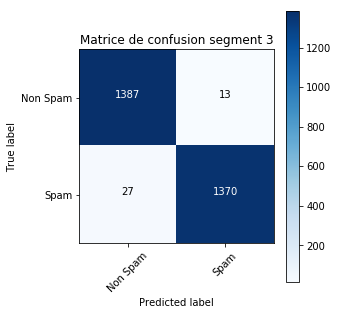

In [88]:
model = LogisticRegression()
k_fold = KFold(n=len(data), n_folds = 4)
pipeline = build_pipeline(model)
scores = []
confusion = numpy.array([[0, 0], [0, 0]])
print("Entainement avec %d segment 4" )
for i, (train_indices, test_indices) in enumerate(k_fold):
    train_text = data.iloc[train_indices]['text'].values
    train_y = data.iloc[train_indices]['class'].values.astype(str)
    test_text = data.iloc[test_indices]['text'].values
    test_y = data.iloc[test_indices]['class'].values.astype(str)

    print("Entrainement pour le segment de validation {}".format(str(i+1)))
    pipeline.fit(train_text, train_y)
    print("Test pour le segment de validation {}".format(str(i+1)))
    predictions = pipeline.predict(test_text)

    confusion += confusion_matrix(test_y, predictions)
    score = f1_score(test_y, predictions, pos_label=SPAM)
    scores.append(score)

    print("Score du modèle %d: %2.2f" % (i, score))
    print("Matrice de Confusion for %d: " % i)
    print(confusion)
    #plt.figure()
plt.figure(figsize=(20, 5))
plt.subplot(1,4,i+1)
plot_confusion_matrix(confusion, classes=['Non Spam','Spam'], normalize=False,
              title='Matrice de confusion segment {}'.format(str(i)))

In [90]:
def train2(data, n_folds, model,text):
    if data is None:
        print("Chargement des données...")
        data = load_data()
        print("Données chargées")
    k_fold = KFold(n=len(data), n_folds = n_folds)
    pipeline = build_pipeline(model)
    scores = []
    confusion = numpy.array([[0, 0], [0, 0]])
    print("Entainement avec %d segment" % n_folds)
    for i, (train_indices, test_indices) in enumerate(k_fold):
        train_text = data.iloc[train_indices][text].values
        train_y = data.iloc[train_indices]['class'].values.astype(str)
        test_text = data.iloc[test_indices][text].values
        test_y = data.iloc[test_indices]['class'].values.astype(str)
        
        print("Entrainement pour le segment de validation {}".format(str(i+1)))
        pipeline.fit(train_text, train_y)
        print("Test pour le segment de validation {}".format(str(i+1)))
        predictions = pipeline.predict(test_text)
        
        confusion += confusion_matrix(test_y, predictions)
        score = f1_score(test_y, predictions, pos_label=SPAM)
        scores.append(score)
        
        print("Score du modèle %d: %2.2f" % (i, score))
        print("Matrice de Confusion for %d: " % i)
        print(confusion)
        #plt.figure()
        plt.figure(figsize=(20, 5))
        plt.subplot(1,4,i+1)
        plot_confusion_matrix(confusion, classes=['Non Spam','Spam'], normalize=False,
                      title='Matrice de confusion segment {}'.format(str(i)))

    print('Total emails Bien classifié:', len(data))
    print('Score moyen des modèles:', sum(scores)/len(scores))
    print('Matrice de confusion:')
    print(confusion)
    return pipeline

### Model d'apprentissage : Régression logistique

Entainement avec 4 segment
Entrainement pour le segment de validation 1
Test pour le segment de validation 1
Score du modèle 0: 0.99
Matrice de Confusion for 0: 
[[363   4]
 [  5 328]]
Confusion matrix, without normalization
[[363   4]
 [  5 328]]
Entrainement pour le segment de validation 2
Test pour le segment de validation 2
Score du modèle 1: 0.99
Matrice de Confusion for 1: 
[[702   7]
 [ 12 678]]
Confusion matrix, without normalization
[[702   7]
 [ 12 678]]
Entrainement pour le segment de validation 3
Test pour le segment de validation 3
Score du modèle 2: 0.98
Matrice de Confusion for 2: 
[[1046   11]
 [  20 1021]]
Confusion matrix, without normalization
[[1046   11]
 [  20 1021]]
Entrainement pour le segment de validation 4
Test pour le segment de validation 4
Score du modèle 3: 0.99
Matrice de Confusion for 3: 
[[1387   13]
 [  27 1370]]
Confusion matrix, without normalization
[[1387   13]
 [  27 1370]]
Total emails Bien classifié: 2797
Score moyen des modèles: 0.985614959220

Pipeline(memory=None,
     steps=[('count_vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
 ...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

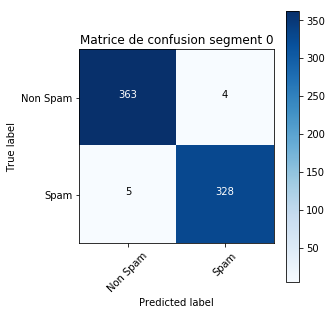

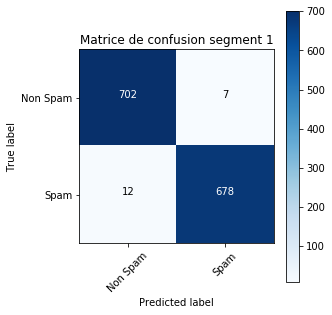

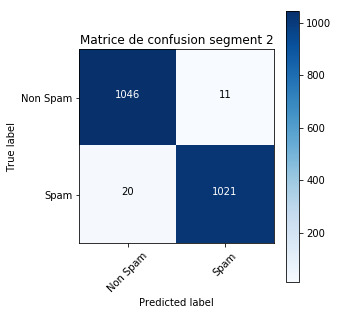

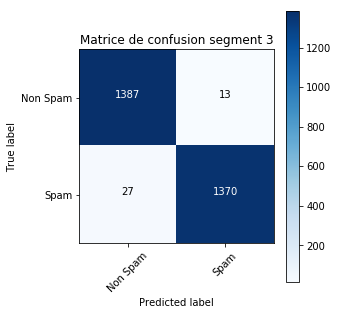

In [91]:
model1 = LogisticRegression()
train2(data,4,model1,'text')

###  Classifieur Bayésien

Entainement avec 4 segment
Entrainement pour le segment de validation 1
Test pour le segment de validation 1
Score du modèle 0: 0.97
Matrice de Confusion for 0: 
[[365   2]
 [ 18 315]]
Confusion matrix, without normalization
[[365   2]
 [ 18 315]]
Entrainement pour le segment de validation 2
Test pour le segment de validation 2
Score du modèle 1: 0.98
Matrice de Confusion for 1: 
[[704   5]
 [ 30 660]]
Confusion matrix, without normalization
[[704   5]
 [ 30 660]]
Entrainement pour le segment de validation 3
Test pour le segment de validation 3
Score du modèle 2: 0.98
Matrice de Confusion for 2: 
[[1049    8]
 [  41 1000]]
Confusion matrix, without normalization
[[1049    8]
 [  41 1000]]
Entrainement pour le segment de validation 4
Test pour le segment de validation 4
Score du modèle 3: 0.98
Matrice de Confusion for 3: 
[[1390   10]
 [  52 1345]]
Confusion matrix, without normalization
[[1390   10]
 [  52 1345]]
Total emails Bien classifié: 2797
Score moyen des modèles: 0.977322271609

Pipeline(memory=None,
     steps=[('count_vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

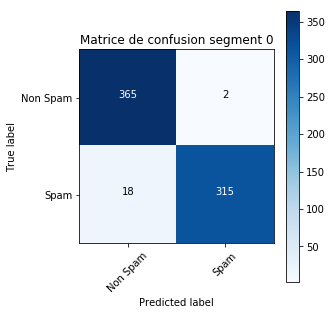

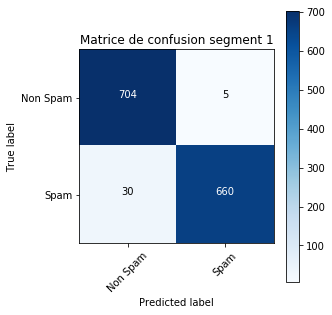

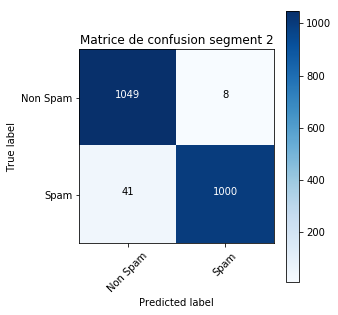

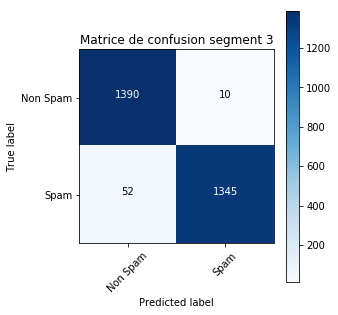

In [92]:
model2 = MultinomialNB()
train2(data,4,model2, 'text')

### Nettoyage des données (Partie 2)

In [93]:
from nltk.tokenize import word_tokenize # compteur de mots
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from nltk.stem import PorterStemmer #retrait des préfixes et suffixes (balayage balayer, balaie)
from nltk.stem import WordNetLemmatizer # redefinit les mots en mots de dictionnaire

In [94]:
stemmer = PorterStemmer()  
lemmatizer = WordNetLemmatizer()
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\computer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [95]:
#vocab_train

Entainement avec 4 segment
Entrainement pour le segment de validation 1
Test pour le segment de validation 1
Score du modèle 0: 0.97
Matrice de Confusion for 0: 
[[359   8]
 [  9 324]]
Confusion matrix, without normalization
[[359   8]
 [  9 324]]
Entrainement pour le segment de validation 2
Test pour le segment de validation 2
Score du modèle 1: 0.98
Matrice de Confusion for 1: 
[[697  12]
 [ 18 672]]
Confusion matrix, without normalization
[[697  12]
 [ 18 672]]
Entrainement pour le segment de validation 3
Test pour le segment de validation 3
Score du modèle 2: 0.98
Matrice de Confusion for 2: 
[[1038   19]
 [  28 1013]]
Confusion matrix, without normalization
[[1038   19]
 [  28 1013]]
Entrainement pour le segment de validation 4
Test pour le segment de validation 4
Score du modèle 3: 0.98
Matrice de Confusion for 3: 
[[1374   26]
 [  35 1362]]
Confusion matrix, without normalization
[[1374   26]
 [  35 1362]]
Total emails Bien classifié: 2797
Score moyen des modèles: 0.978029256754

Pipeline(memory=None,
     steps=[('count_vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
 ...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

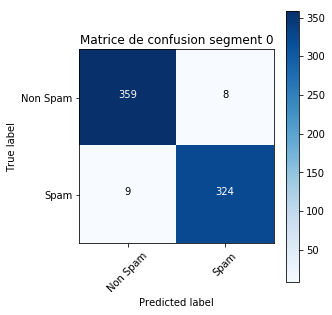

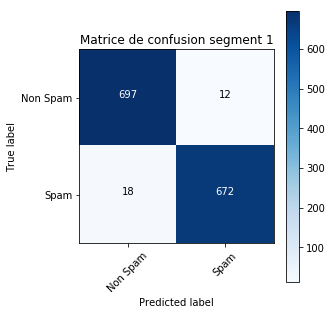

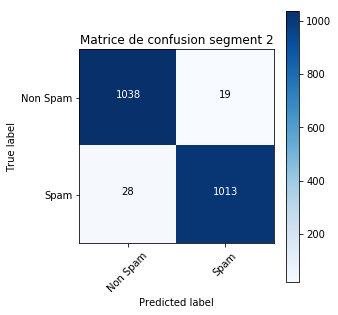

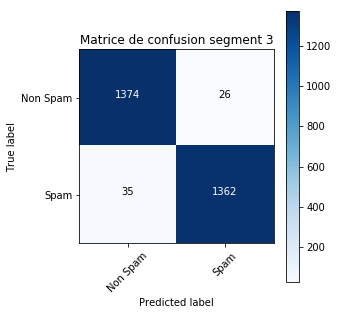

In [96]:
train2(data,4,model1,'word_clean')

In [ ]:
# Installation de word cloud
#!wget http://nlp.stanford.edu/data/glove.6B.zip
!python -m pip install wordcloud

In [ ]:
from wordcloud import WordCloud, STOPWORDS #Visualisation des nuages de mot

In [ ]:
spam_text = data[data['class']=='spam']
ham_text = data[data['class']=='ham']

In [ ]:
ham_text

In [ ]:
# Construction des mots à partir de l'analyseur lexical peut prendre du temps

dat_spam = data[data['class']=='spam']
dat_ham = data[data['class']=='ham']
filtered_data_spam = dat_spam['word_clean']
filtered_data_ham = dat_ham['word_clean']
vocab_spam = [word_tokenize(o) for o in filtered_data_spam[0:5]]
vocab_ham = [word_tokenize(o) for o in filtered_data_ham[0:5]]
#x_test = [word_tokenize(o) for o in x_test]

In [277]:
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown','the','to'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  

In [98]:
#vocab_spam

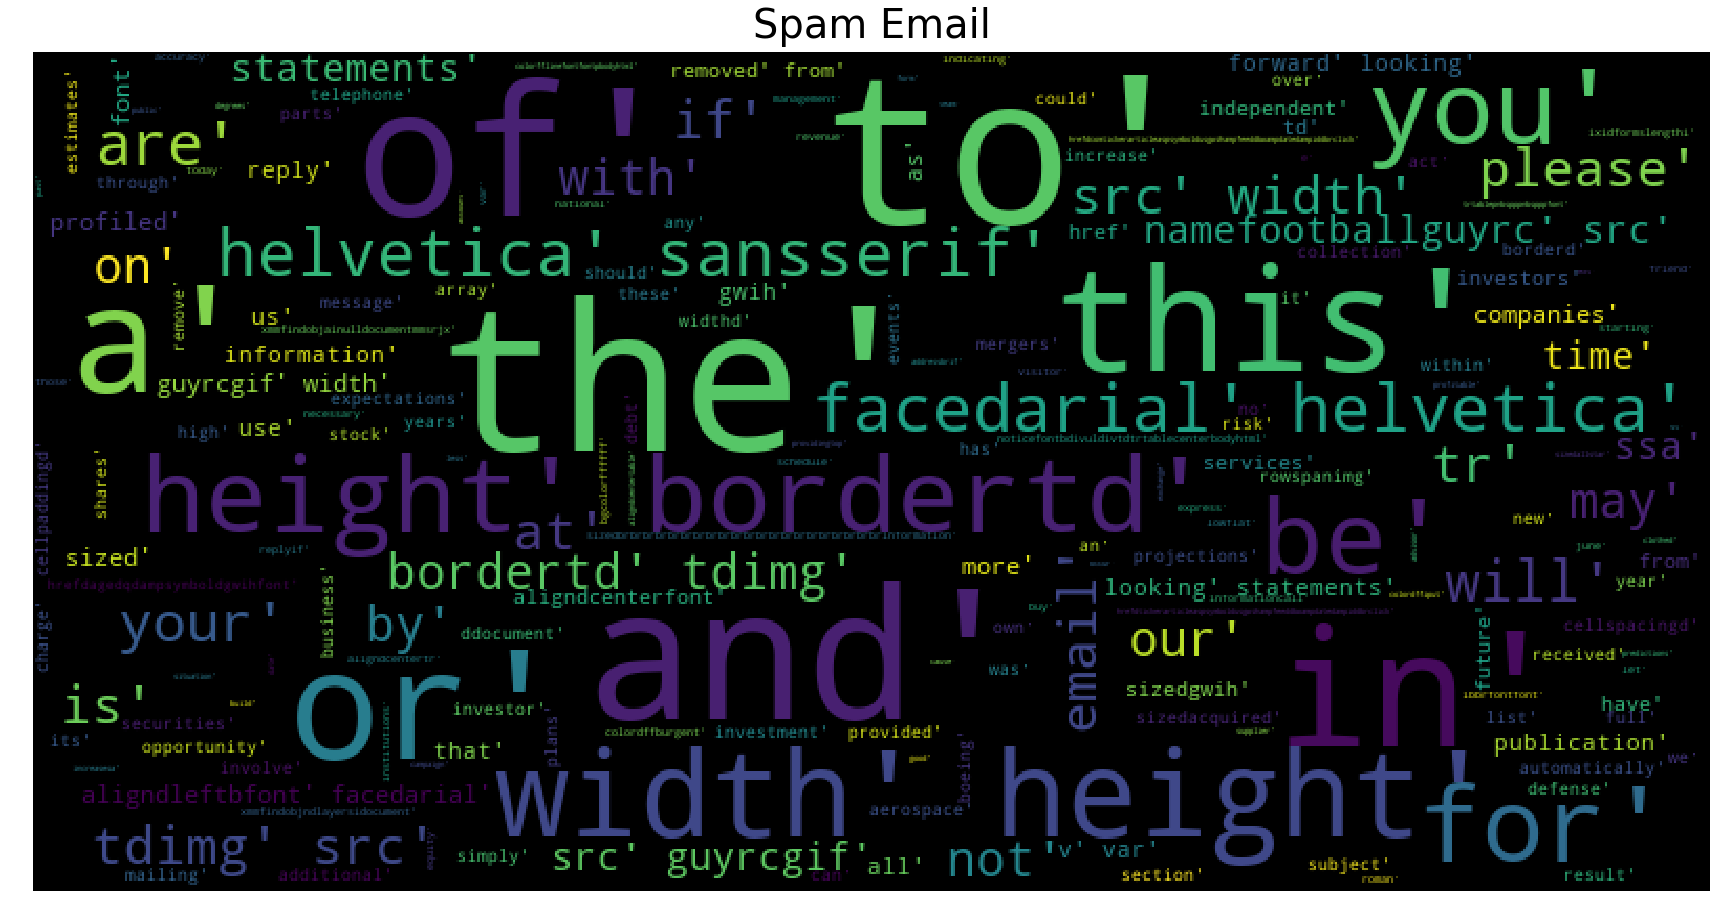

In [278]:
plot_wordcloud(vocab_spam,title = 'Spam Email')